# Naive Bayes Classifier

Naive Bayes classifiers are linear classifiers are based on Bayes’ theorem; they are termed "naive" because they rely on the assumption that the features in a data set are mutually independent [1]. Bayes' theorem is as follows: <br>

$$ P(A|B) = \frac{P(B|A)P(A)}{P(B)} $$ <br>

In other words, we are updating our beliefs based on the observation of evidence: <br>

$$ prob_{posterior} = \frac{prob_{conditional} \cdot prob_{prior}}{evidence} $$ <br>

[1] T. M. Mitchell, 2015. *Machine Learning*. "Chapter 3: Generative and Discriminative Classifiers: Naive Bayes and Logistic Regression." [Online](https://www.cs.cmu.edu/~tom/mlbook/NBayesLogReg.pdf)

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

### Loading and Restructuring Data

We first load in the sample data generated in the Data Merging stage. We need to transform each issue area and decision direction into dummy variables in order to train the classifier on them (analogizing this process to the lab Rotten Tomatoes example, belonging to an issue area or not would constitute being "fresh" or not). 

In [2]:
sample_df = pd.read_csv("sample_cases.csv")

In [3]:
# turn issue areas into dummy column
issue_areas = ["criminal procedure","civil rights","first amendment","due process","privacy","attorneys",
              "unions","economic activity","judicial power","federalism","interstate  amendment",
              "federal taxation","miscellaneous","private action"]

for issue, num in zip(issue_areas,range(1,15)):
    sample_df[issue] = sample_df.issueArea.apply(lambda x: 1 if x == num else 0)

In [4]:
# turn decision directions into dummy column (conservative, liberal, neutral)
decision_areas = ["conservative","liberal","neutral"]

for decision, num in zip(decision_areas,range(1,4)):
    sample_df[decision] = sample_df.decisionDirection.apply(lambda x: 1 if x == num else 0)

### Vectorizing Text

We use the function **make_xy** to convert the syllabi (a collection of text documents) to numerical data (a matrix of token counts). The default vectorizer we use for this task is CountVectorizer, which produces a sparse representation of the counts.

In [5]:
# function (from lab 9) to vectorize text - adapted to accomodate topics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def make_xy(df, issue, vectorizer=None):   
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.text)
    X = X.tocsc()
    y = (df[issue] == 1).values.astype(np.int)
    return X, y

### Cross-Validation

We use the function **cv_score** to estimate the cross-validated value of a scoring function, given a classifier and data. In k-fold cross-validation, the test set is no longer needed; rather, the training set is split into *k* smaller sets. The following procedure is followed for each of the k “folds”: (1) the model is trained using k-1 of the folds as training data, (b) the model is validated on the remaining part of the data, (3) the performance of the model is 
calculated as the average of the values computed in the loop. Because we are working with a relatively small data sample (about 1,600 cases), approaches that are efficient in terms of data usage are preferable.

In [6]:
from sklearn.cross_validation import KFold

# function to return cross-validation score (lab 9)
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

### Log Probabilities

We define a function to return an array of log probabilities of the samples for each class in the model.

In [7]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    not_topic = y == 0
    topic = ~not_topic
    return prob[not_topic, 0].sum() + prob[topic, 1].sum()

### Model Calibration

Now that we can compute the probabilities of each classification, we should should also assess whether these probabilities are calibrated. Calibration entails: (1) computing the topic probability for an example using clf.predict_proba, (2) gather examples into bins of similar topic probability, (3) calculate the fraction of examples in the bin which are in the topic. If the model is calibrated, the line plot should follow *y=x*.

In [69]:
"""
Function
--------
calibration_plot
Builds a plot from a classifier and review data

Inputs
-------
clf : Classifier object
    A MultinomialNB classifier
X : (Nexample, Nfeature) array
    The bag-of-words data
Y : (Nexample) integer array
    1 if an opinion is in a certain topic
"""    

def calibration_plot(clf, issue, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #topic ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'], color='#7ddbca')
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='#7ddbca')
    plt.ylabel("Empirical P(%s)" % issue)
    
    #the distribution of P(topic)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color(), alpha=0.7, linewidth=0)
    
    plt.xlabel("Predicted P(%s)" % issue)
    plt.ylabel("Number")

### Running the Model

Using the supporting functions above, we can now classify each issue area and store the output. 

In [353]:
# function to run all commands above in sequence
def run_multinb(df, issue):
    
    # create a mask to split data into test and training sets
    itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)
    mask = np.ones(df.shape[0], dtype='int')
    mask[itrain] = 1
    mask[itest] = 0
    mask = (mask == 1)
    
    #the grid of parameters to search over
    alphas = [0, .1, 1, 5, 10, 50]
    min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

    # find the best value for alpha and min_df, and the best classifier
    best_alpha = None
    best_min_df = None
    maxscore = -np.inf
    for alpha in alphas:
        for min_df in min_dfs:         
            vectorizer = CountVectorizer(min_df = min_df)       
            Xthis, ythis = make_xy(df, issue, vectorizer)
            Xtrainthis = Xthis[mask]
            ytrainthis = ythis[mask]
            clf = MultinomialNB(alpha=alpha)
            cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
            if cvscore > maxscore:
                maxscore = cvscore
                best_alpha, best_min_df = alpha, min_df
    
    print issue.upper()
    print "---------------"
    
    # print and store best alpha values, fit the model on training data on these
    print "alpha: %f" % best_alpha
    print "min_df: %f" % best_min_df
    best_alphas.append(best_alpha)
    best_min_dfs.append(best_min_df)
    vectorizer = CountVectorizer(min_df = best_min_df)
    X, y = make_xy(df, issue, vectorizer)
    xtrain, ytrain, xtest, ytest = X[mask], y[mask], X[~mask], y[~mask]
    clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

    # store and print train and test accuracy
    print "------"
    train_acc.append(clf.score(xtrain, ytrain))
    test_acc.append(clf.score(xtest, ytest))
    print "Accuracy on training data: %0.2f" % (clf.score(xtrain, ytrain))
    print "Accuracy on test data:     %0.2f" % (clf.score(xtest, ytest))
    
    # store and print true/false pos/negs
    tp.append(confusion_matrix(ytest, clf.predict(xtest))[0][0])
    fp.append(confusion_matrix(ytest, clf.predict(xtest))[1][0])
    fn.append(confusion_matrix(ytest, clf.predict(xtest))[0][1])
    tn.append(confusion_matrix(ytest, clf.predict(xtest))[1][1])
    print "------"
    print "True positives:", confusion_matrix(ytest, clf.predict(xtest))[0][0]
    print "False positives:", confusion_matrix(ytest, clf.predict(xtest))[1][0]
    print "False negatives:", confusion_matrix(ytest, clf.predict(xtest))[0][1]
    print "True negatives:", confusion_matrix(ytest, clf.predict(xtest))[1][1]
    
    # get features from results
    words = np.array(vectorizer.get_feature_names())
    x = np.eye(xtest.shape[1])
    probs = clf.predict_log_proba(x)[:, 0]
    ind = np.argsort(probs)

    # top 10 words associated with topic
    good_prob = probs[ind[:10]]
    good_words = words[ind[:10]]
    rep_words.append(good_words)

    print "------"
    print "Words yielding highest P(%s | word)" % issue
    for w, p in zip(good_words, good_prob):
        print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
    # predict probability of belonging to topic
    prob = clf.predict_proba(X)[:, 0]
    prob_dict[issue] = prob
    predict = clf.predict(X)
    predict_dict[issue] = predict
    
    # print false positives and false negatives
    bad_fp = np.argsort(prob[y == 0])[:5]
    bad_fn = np.argsort(prob[y == 1])[-5:]
    
    print "False positive cases:"
    print '---------------------------'
    for row in bad_fp:
        print df[y == 0].case.irow(row)

    print
    print "False negative cases:"
    print '--------------------------'
    for row in bad_fn:
        print df[y == 1].case.irow(row)
    
    # calibration plot
    calibration_plot(clf, issue, xtest, ytest)

In [71]:
# we can now repeat this process for all 14 topics
issue_areas = ["criminal procedure","civil rights","first amendment","due process","privacy","attorneys",
              "unions","economic activity","judicial power","federalism","interstate  amendment",
              "federal taxation","miscellaneous","private action"]

CRIMINAL PROCEDURE
---------------
alpha: 50.000000
min_df: 0.100000
------
Accuracy on training data: 0.88
Accuracy on test data:     0.87
------
True positives: 347
False positives: 40
False negatives: 24
True negatives: 68
------
Words yielding highest P(criminal procedure | word)
           convicted 0.58
                jury 0.55
               trial 0.52
          conviction 0.52
           defendant 0.51
            criminal 0.50
            evidence 0.44
                  he 0.41
       circumstances 0.40
                 his 0.39
False positive cases:
---------------------------
Strickland v. Washington
Lee v. Kemna
Pate v. Robinson
Martin v. Ohio
Bunkley v. Florida

False negative cases:
--------------------------
Dorsey v. United States
Kimbrough v. United States
Republic of Austria v. Altman
California Bankers Assn. v. Shultz
Boumediene v. Bush


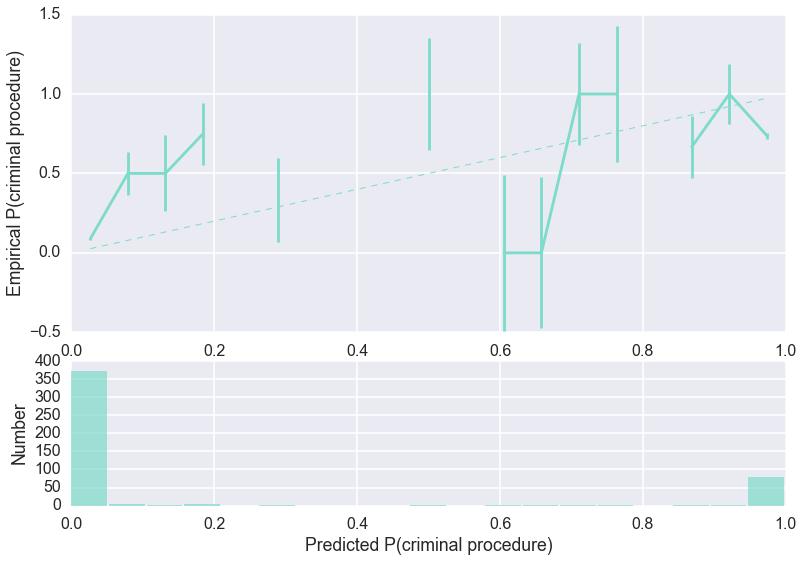

In [354]:
# data fields to store model outputs
best_alphas,best_min_dfs,train_acc,test_acc,tp,fp,tn,fn,rep_words = [],[],[],[],[],[],[],[],[]
predict_dict = {}
prob_dict = {}

# start with issue 1 (criminal procedure)
run_multinb(sample_df, issue_areas[0])

CIVIL RIGHTS
---------------
alpha: 10.000000
min_df: 0.100000
------
Accuracy on training data: 0.81
Accuracy on test data:     0.78
------
True positives: 339
False positives: 46
False negatives: 59
True negatives: 35
------
Words yielding highest P(civil rights | word)
          protection 0.37
             persons 0.35
                 her 0.34
         opportunity 0.34
         requirement 0.33
              system 0.31
                supp 0.30
          fourteenth 0.30
             provide 0.29
          individual 0.29
False positive cases:
---------------------------
Vieth v. Jubelirer
Michael H. v. Gerald D.
Warth v. Seldin
Wilkinson v. Austin
United States v. Dalm

False negative cases:
--------------------------
Ludecke v. Watkins
Hobby v. United States
Purkett v. Elem
Strickland v. Washington
Costello v. United States


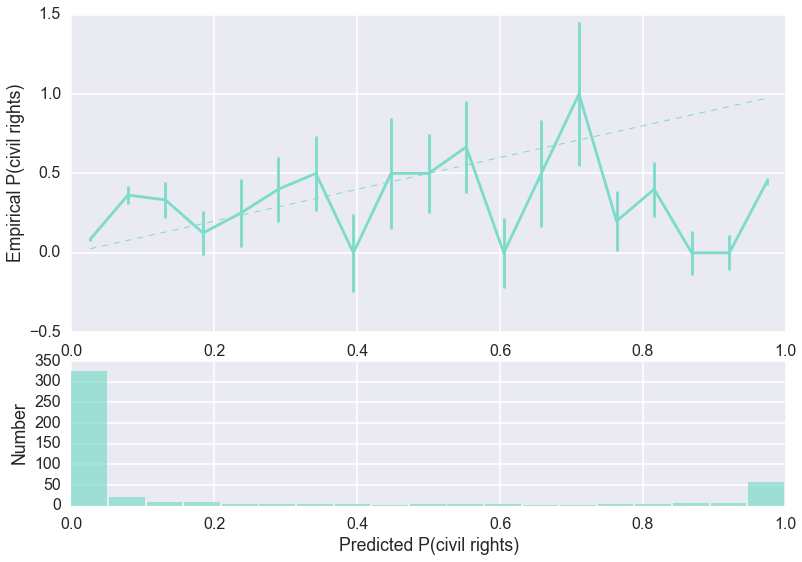

In [355]:
run_multinb(sample_df, issue_areas[1])

FIRST AMENDMENT
---------------
alpha: 0.100000
min_df: 0.100000
------
Accuracy on training data: 0.94
Accuracy on test data:     0.87
------
True positives: 392
False positives: 27
False negatives: 36
True negatives: 24
------
Words yielding highest P(first amendment | word)
              public 0.30
               first 0.25
            exercise 0.25
            interest 0.21
           interests 0.20
           amendment 0.19
               means 0.19
         substantial 0.19
            judicial 0.14
          fourteenth 0.14
False positive cases:
---------------------------
Grutter v. Bollinger
Parents Involved in Community Schools v. Seattle School Dist. No.
Abood v. Detroit Bd. of Educ.
United Haulers Assn., Inc. v. Oneida-Herkimer Solid Waste Management Authority
Crawford v. Marion County Election Bd.

False negative cases:
--------------------------
Parisi v. Davidson
United States v. Weller
McGee v. United States
Eagles v. Samuels
Bryson v. United States


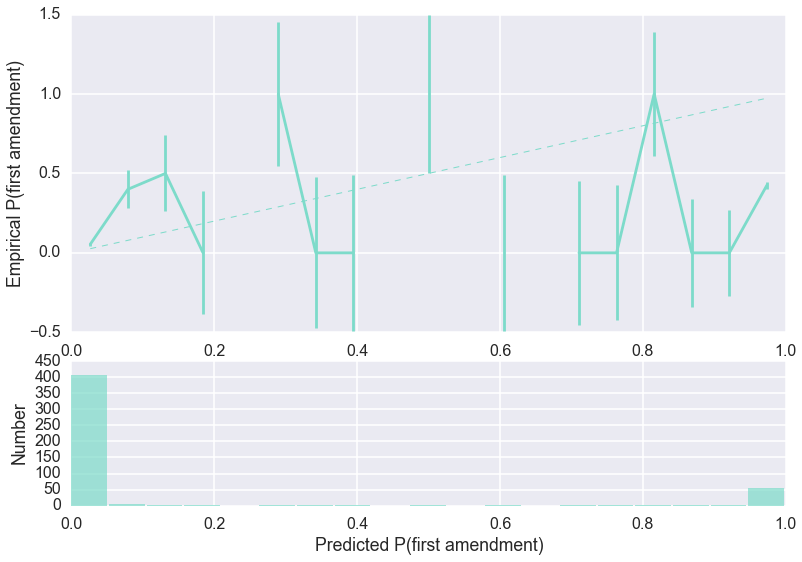

In [356]:
run_multinb(sample_df, issue_areas[2])

DUE PROCESS
---------------
alpha: 5.000000
min_df: 0.100000
------
Accuracy on training data: 0.96
Accuracy on test data:     0.95
------
True positives: 450
False positives: 8
False negatives: 16
True negatives: 5
------
Words yielding highest P(due process | word)
            property 0.21
                 due 0.18
             process 0.15
             hearing 0.14
         opportunity 0.12
            interest 0.11
             nothing 0.11
                used 0.10
          authorized 0.10
          sufficient 0.09
False positive cases:
---------------------------
United States v. National Bank of Commerce
Mathews v. Eldridge
Lassiter v. Department of Social Svcs.
Allegheny-Pittsburgh Coal Co. v. County Comm'n
United States v. Whiting Pools, Inc.

False negative cases:
--------------------------
May v. Anderson
Dusky v. United States
Liteky v. United States
Turner v. United States
Ivanhoe Irrigation Dist. v. McCracken


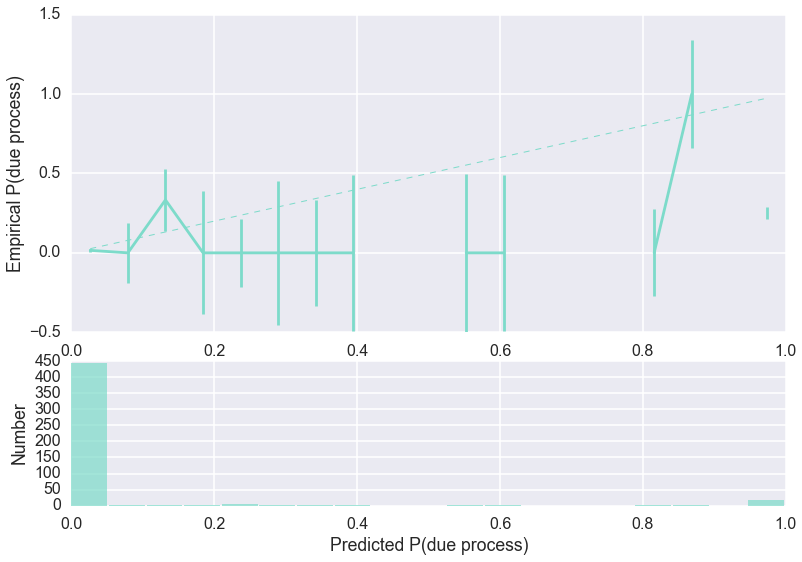

In [357]:
run_multinb(sample_df, issue_areas[3])

PRIVACY
---------------
alpha: 1.000000
min_df: 0.100000
------
Accuracy on training data: 0.98
Accuracy on test data:     0.97
------
True positives: 465
False positives: 4
False negatives: 10
True negatives: 0
------
Words yielding highest P(privacy | word)
               board 0.04
            relevant 0.03
             related 0.03
           procedure 0.03
         enforcement 0.03
                give 0.03
            contrary 0.03
       determination 0.03
               inter 0.03
             provide 0.03
False positive cases:
---------------------------
Parents Involved in Community Schools v. Seattle School Dist. No.
NLRB v. Curtin Matheson
Salazar v. Ramah Navajo Chapter
Oppenheimer Fund, Inc. v. Sanders
Railway Clerks v. Employees Ass'n

False negative cases:
--------------------------
Bowers v. Hardwick
GTE Sylvania, Inc. v. Consumers Union
Department of State v. Ray
Kissinger v. Reporters Committee
Chandler v. Miller


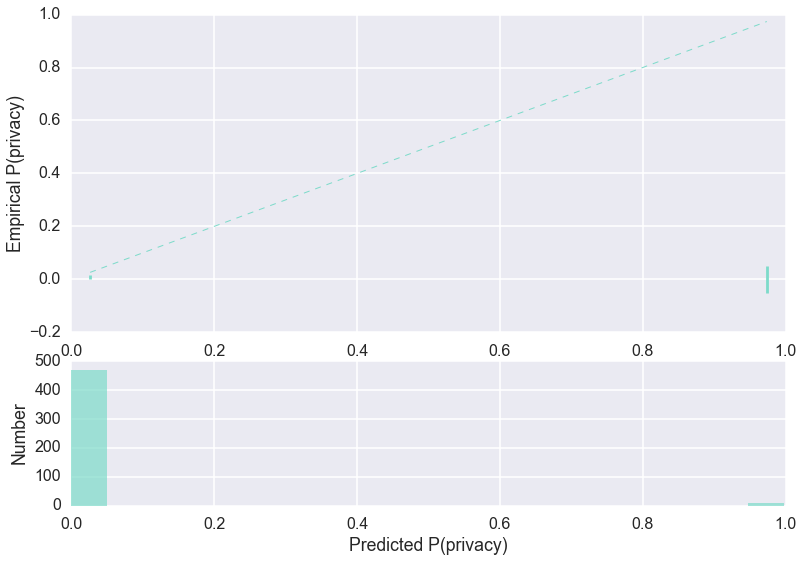

In [358]:
run_multinb(sample_df, issue_areas[4])

ATTORNEYS
---------------
alpha: 1.000000
min_df: 0.100000
------
Accuracy on training data: 1.00
Accuracy on test data:     0.99
------
True positives: 470
False positives: 7
False negatives: 0
True negatives: 2
------
Words yielding highest P(attorneys | word)
            attorney 0.08
               civil 0.05
                text 0.04
              rights 0.04
             persons 0.03
             history 0.03
                  11 0.03
               makes 0.03
           complaint 0.02
         respondents 0.02
False positive cases:
---------------------------
Kimberlin v. Quinlan
BP America Production Co. v. Burton
Shearson/American Express v. McMahon
Rotella v. Wood
Taniguchi v. Kan Pacific Saipan, Ltd.

False negative cases:
--------------------------
United States v. R. F. Ball Construction Co., Inc.
Ohralik v. Ohio State Bar Assn.
Gisbrecht v. Barnhart
Konigsberg v. State Bar of California
In re Primus


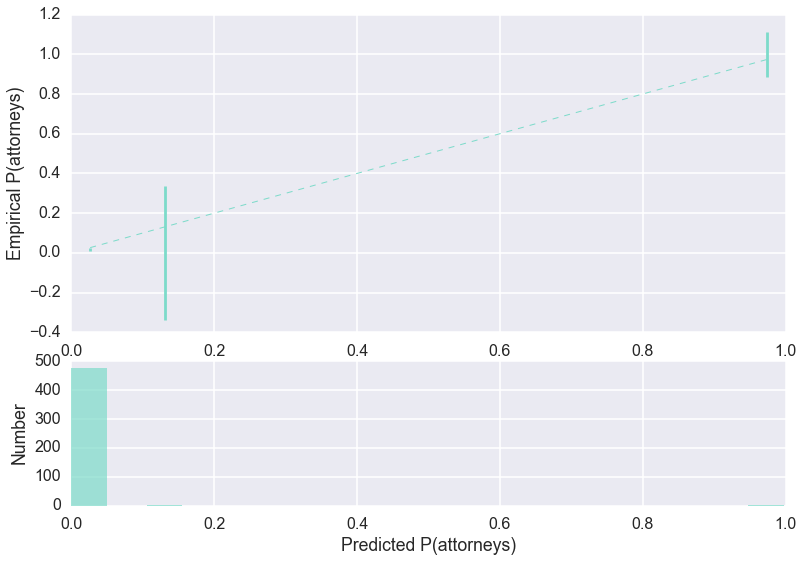

In [359]:
run_multinb(sample_df, issue_areas[5])

UNIONS
---------------
alpha: 10.000000
min_df: 0.100000
------
Accuracy on training data: 0.97
Accuracy on test data:     0.94
------
True positives: 437
False positives: 8
False negatives: 20
True negatives: 14
------
Words yielding highest P(unions | word)
               labor 0.60
           employees 0.45
               board 0.29
            practice 0.24
            national 0.24
             members 0.20
             ordered 0.16
      interpretation 0.14
                corp 0.13
               local 0.13
False positive cases:
---------------------------
Algoma Plywood v. Wisconsin Board
Universal Camera Corp. v. Labor Board
Railway Clerks v. Employees Ass'n
Renegotiation Bd. v. Grumman Aircraft
Labor Board v. Mexia Textile Mills, Inc.

False negative cases:
--------------------------
Foley Bros., Inc. v. Filardo
Cuyahoga Valley Ry. v. United Transp. Union
United Paperworkers v. Misco, Inc.
Wright v. Universal Maritime Service Corp.
Abood v. Detroit Bd. of Educ.


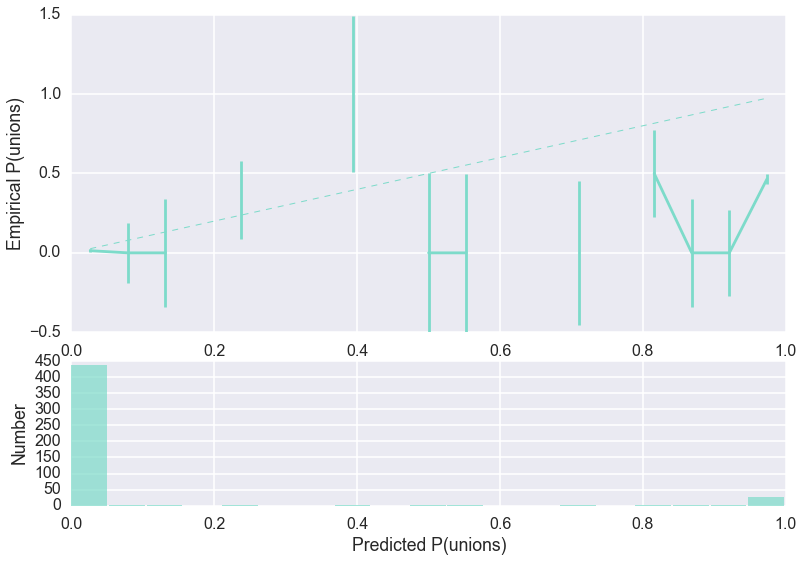

In [360]:
run_multinb(sample_df, issue_areas[6])

ECONOMIC ACTIVITY
---------------
alpha: 10.000000
min_df: 0.100000
------
Accuracy on training data: 0.77
Accuracy on test data:     0.75
------
True positives: 291
False positives: 11
False negatives: 108
True negatives: 69
------
Words yielding highest P(economic activity | word)
           liability 0.54
                corp 0.52
                  co 0.49
          commission 0.48
                 inc 0.47
                  17 0.42
      interpretation 0.41
                 act 0.37
             meaning 0.36
            language 0.36
False positive cases:
---------------------------
United States v. Rock Island Motor Transit Co.
Meyer v. Holley
Dorsey v. United States
Scheidler v. National Organization for Women, Inc.
Humana Inc. v. Forsyth

False negative cases:
--------------------------
United States v. Mississippi Valley Generating Co.
Nixon v. Fitzgerald
United States v. Stanley
Paroline v. United States
Weisgram v. Marley Co.


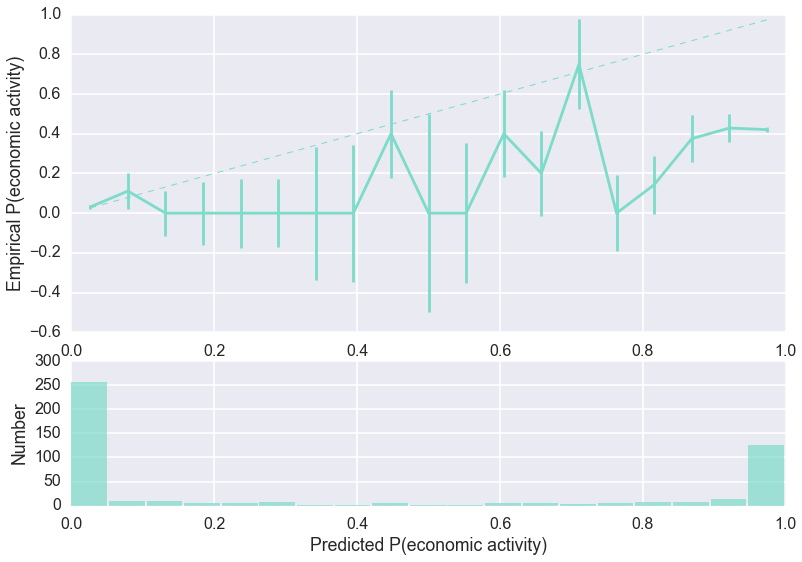

In [361]:
run_multinb(sample_df, issue_areas[7])

JUDICIAL POWER
---------------
alpha: 10.000000
min_df: 0.100000
------
Accuracy on training data: 0.84
Accuracy on test data:     0.81
------
True positives: 355
False positives: 25
False negatives: 68
True negatives: 31
------
Words yielding highest P(judicial power | word)
        jurisdiction 0.35
              appeal 0.35
           dismissed 0.34
             vacated 0.29
              motion 0.29
              courts 0.29
                  28 0.29
           complaint 0.28
              review 0.27
                suit 0.27
False positive cases:
---------------------------
Arbaugh v. Y & H Corp.
Kloeckner v. Solis
Strate v. A-1 Contractors
Affiliated Tribes v. Wold Engineering
Coleman v. Thompson

False negative cases:
--------------------------
Taniguchi v. Kan Pacific Saipan, Ltd.
Flemming v. Florida Citrus Exchange
Good Samaritan Hospital v. Shalala
Valley Forge Coll. v. Americans United
United States v. Rock Island Motor Transit Co.


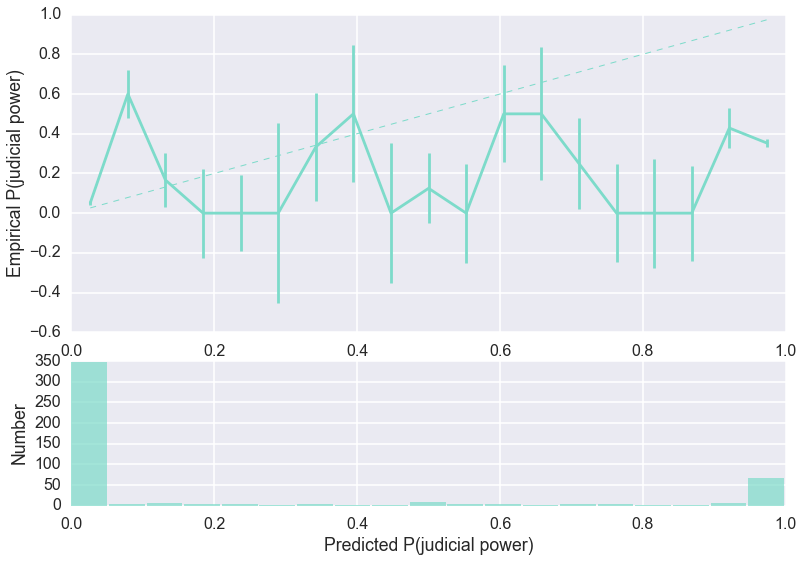

In [362]:
run_multinb(sample_df, issue_areas[8])

FEDERALISM
---------------
alpha: 10.000000
min_df: 0.100000
------
Accuracy on training data: 0.92
Accuracy on test data:     0.88
------
True positives: 416
False positives: 17
False negatives: 39
True negatives: 7
------
Words yielding highest P(federalism | word)
              common 0.17
             entered 0.15
               labor 0.14
               power 0.14
                corp 0.14
               rules 0.13
        constitution 0.13
               local 0.12
                laws 0.12
               terms 0.12
False positive cases:
---------------------------
Automobile Workers v. Wisconsin Board
MeadWestvaco Corp. v. Illinois Dept. of Revenue
Preseault v. ICC
Watson v. Philip Morris Cos.
United Haulers Assn., Inc. v. Oneida-Herkimer Solid Waste Management Authority

False negative cases:
--------------------------
McCarty v. McCarty
United States v. California
Taggart v. Weinacker's, Inc.
Levinson v. Deupree
Nebraska Dept. of Revenue v. Loewenstein


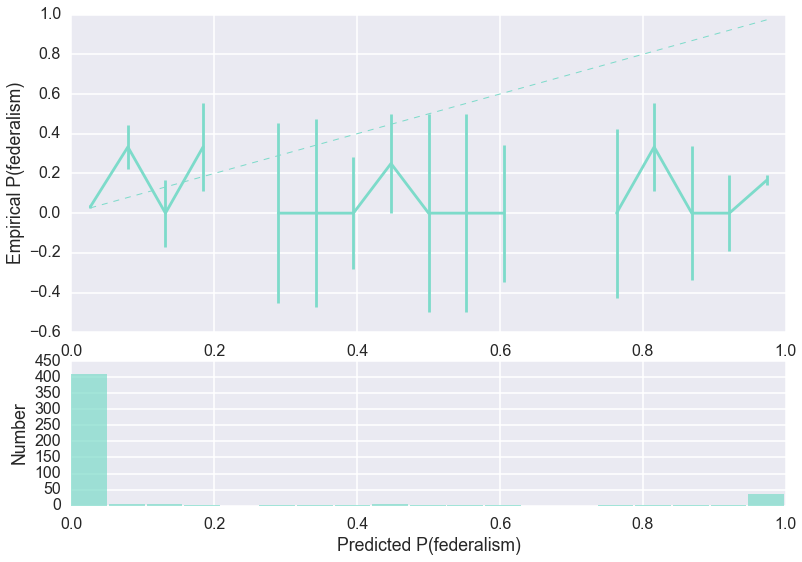

In [363]:
run_multinb(sample_df, issue_areas[9])

INTERSTATE  AMENDMENT
---------------
alpha: 5.000000
min_df: 0.100000
------
Accuracy on training data: 0.98
Accuracy on test data:     0.99
------
True positives: 470
False positives: 0
False negatives: 7
True negatives: 2
------
Words yielding highest P(interstate  amendment | word)
             entered 0.11
             ordered 0.08
             summary 0.06
                  14 0.05
              having 0.05
           complaint 0.05
           establish 0.05
                  26 0.05
         established 0.05
            december 0.05
False positive cases:
---------------------------
United States v. California
United States v. Louisiana
United States v. Louisiana
United States v. Maine
California State Lands Comm'n v. United States

False negative cases:
--------------------------
Nebraska v. Iowa
Cook v. Cook
Ohio v. Kentucky
Nebraska v. Wyoming
Colorado v. New Mexico


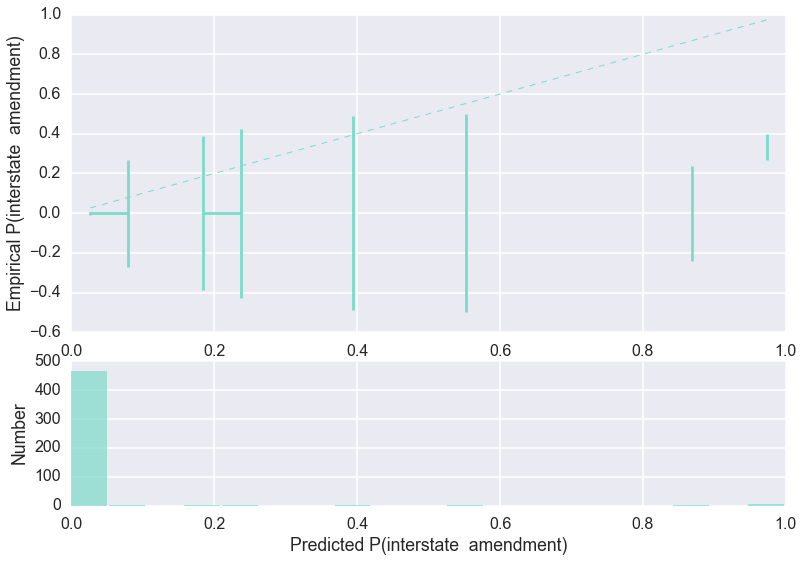

In [364]:
run_multinb(sample_df, issue_areas[10])

FEDERAL TAXATION
---------------
alpha: 5.000000
min_df: 0.100000
------
Accuracy on training data: 0.91
Accuracy on test data:     0.87
------
True positives: 411
False positives: 7
False negatives: 54
True negatives: 7
------
Words yielding highest P(federal taxation | word)
               years 0.13
                  26 0.12
                  23 0.09
                  19 0.09
              having 0.09
              making 0.09
           unanimous 0.09
       distinguished 0.08
            specific 0.08
               shall 0.08
False positive cases:
---------------------------
Sun Oil Co. v. FPC
United States v. California
United States v. Korpan
Young v. United States
Soriano v. United States

False negative cases:
--------------------------
Holywell Corp. v. Smith
Colonial Amer. Life Ins. v. Commissioner
United States v. Munoz-Flores
Commissioner v. Engle
United States v. National Bank of Commerce


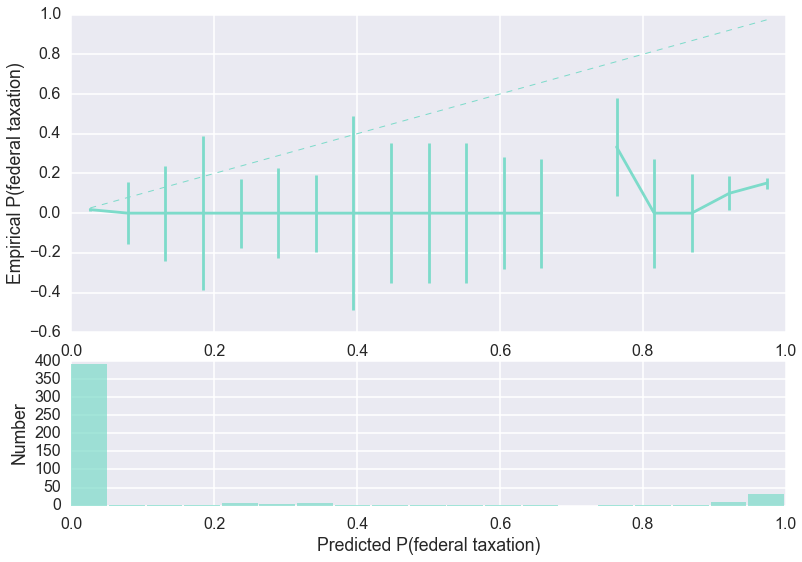

In [365]:
run_multinb(sample_df, issue_areas[11])

MISCELLANEOUS
---------------
alpha: 1.000000
min_df: 0.100000
------
Accuracy on training data: 1.00
Accuracy on test data:     0.99
------
True positives: 474
False positives: 2
False negatives: 3
True negatives: 0
------
Words yielding highest P(miscellaneous | word)
          department 0.02
         respondents 0.01
            argument 0.01
              effect 0.01
             nothing 0.01
          individual 0.01
      administrative 0.01
                  26 0.01
         enforcement 0.01
            criminal 0.01
False positive cases:
---------------------------
Salazar v. Ramah Navajo Chapter
Mobil Oil Exploration & Producing Southeast, Inc. v. United States
Department of Commerce v. Montana
North Dakota v. United States
United States v. Louisiana

False negative cases:
--------------------------
United States v. Stuart
Clinton v. City of New York
Hawaii v. Office of Hawaiian Affairs
Morrison v. Olson
Mistretta v. United States


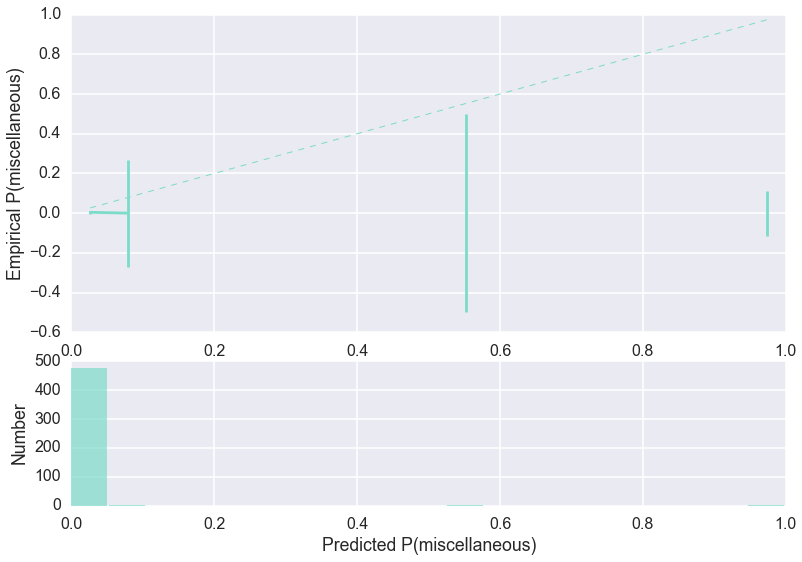

In [366]:
run_multinb(sample_df, issue_areas[12])

We exclude private action cases because there are not enough in the sample to produce interpretable results. The calibration plots for issue areas with small data sets (privacy, attorneys, interstate amendment) are significantly skewed by the small sample size. Most of the models tend to yield underestimated values when predicting whether or not a case belongs to a topic, as demonstrated by the slant of the calibration plot (slope < 1). The large range of the error plots also indicates that for each predicted probability, there is a large amount of variance in the corresponding empirical probability of any topic being assigned.

### Accuracy by Aggregated Probabilities

We can also calculate the accuracy of the model overall by aggregating the topic probabilities generated by each binary model and taking the maximum probability of each of these arrays (functionally finding which topic any given case is most likely to belong to). Because we have stored the probabilities associated with each case prediction in a list, we can format these values into a matrix and use the argmax function here.

In [292]:
# make the probabilities into a dataframe
prob_df = pd.DataFrame(prob_dict)
prob_df = prob_df[issue_areas[:-1]]
prob_df.head()

,criminal procedure,civil rights,first amendment,due process,privacy,attorneys,unions,economic activity,judicial power,federalism,interstate amendment,federal taxation,miscellaneous
0,4.905127e-04,1.000000e+00,0.999999,1.000000,1.000000,1.000000,1.00000,0.997131,1.000000,1.000000,1,1.000000,1
1,9.999987e-01,9.996457e-01,1.000000,1.000000,1.000000,0.999999,1.00000,0.957599,0.000618,1.000000,1,1.000000,1
2,9.999939e-01,9.999817e-01,1.000000,0.999896,1.000000,1.000000,1.00000,0.052769,0.951736,0.999993,1,0.994065,1
3,1.557749e-14,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1,1.000000,1
4,1.000000e+00,4.500681e-10,0.992973,1.000000,0.992929,1.000000,0.47536,0.999998,0.999283,1.000000,1,1.000000,1


Because we discovered in exploratory analysis (section below) that very few cases are assigned to 4 or more topics but a sizable amount of cases are assigned to 3 topics, we devised the following method for calculating the overall performance of the model. Instead of determining whether the topic with the highest probability was the actual issue area, we enable some flexibility by determinig whether the topics with the *highest three* probabilities include the actual issue area. This is valid because we have determined that the model assigned 3 topics to a sizable portion of cases, and allows us to account for "gray area" cases that are more difficult to classify.

In [332]:
import bottleneck as bn 

# make the probabilities into a matrix, take top threee topics associated with max values
prob_matrix = prob_df.as_matrix()
prob_issues = map(lambda x: list(bn.argpartsort(x,3)[:3]), prob_matrix)

In [333]:
# map indices to issue areas and add results to original sample dataframe
sample_df["predicted_issue_area"] = [[x+1 for x in y] for y in prob_issues] 

# store correct predictions in a new accuracy column
sample_df["predicted_correctly"] = [1 if x in y else 0 for y,x in zip(sample_df["predicted_issue_area"], sample_df["issueArea"])]
print "Accuracy across all issue areas: ", float(float(sum(sample_df["predicted_correctly"]))/float(len(sample_df)))

Accuracy across all issue areas:  0.848902821317


In [374]:
sample_df[["issueArea","predicted_correctly","predicted_issue_area"]].head()

,issueArea,predicted_correctly,predicted_issue_area
0,1,1,"[1, 8, 3]"
1,9,1,"[9, 8, 2]"
2,8,1,"[8, 9, 12]"
3,1,1,"[1, 2, 4]"
4,9,0,"[7, 2, 5]"


As we can see from the overall performance and individual performances of the binary categories, the Naive Bayes approach yields high accuracy rates when assigning topics to cases.

### Exploring Results

Now that we have run Naive Bayes classification on all of the topic areas (except private action, which was too underrepresented in the sample to input into the classifier). We can plot the performances of each model we ran above (measured by test vs. training data accuracy, sensitivity or true positive rate, and specificity or true negative rate). We can also explore how predictions are distributed across the issue areas, and dig into the data by checking out the cases that had more than one category assigned to them.

In [371]:
# create dataframe of output from modeling
model_dict = {}
model_dict["issue"] = issue_areas[:-1]
model_dict["best alpha"] = best_alphas
model_dict["best min_df"] = best_min_dfs
model_dict["training_accuracy"] = train_acc
model_dict["test_accuracy"] = test_acc
model_dict["tp"] = tp
model_dict["tn"] = tn
model_dict["fp"] = fp
model_dict["fn"] = fn
model_dict["words"] = rep_words
model_df = pd.DataFrame(model_dict)

In [373]:
# calculate specificity (true neg rate) and sensitivity (true pos rate)
tpr = [float(float(a) / float(a+b)) for a,b in zip(tp,fn)]
tnr = [float(float(a) / float(a+b)) for a,b in zip(tn,fp)]
model_df["sensitivity"] = tpr
model_df["specificity"] = tnr

# save this csv for comparison for final notebook (on full data set)
model_df.to_csv("naive_bayes_sample_model_results.csv", sep=',', encoding='utf-8',index=False)
model_df.head()

,best alpha,best min_df,fn,fp,issue,test_accuracy,tn,tp,training_accuracy,words,sensitivity,specificity
0,50.0,0.1,24,40,criminal procedure,0.866388,68,347,0.880824,"[convicted, jury, trial, conviction, defendant...",0.935310,0.629630
1,10.0,0.1,59,46,civil rights,0.780793,35,339,0.809140,"[protection, persons, her, opportunity, requir...",0.851759,0.432099
2,0.1,0.1,36,27,first amendment,0.868476,24,392,0.938172,"[public, first, exercise, interest, interests,...",0.915888,0.470588
3,5.0,0.1,16,8,due process,0.949896,5,450,0.956093,"[property, due, process, hearing, opportunity,...",0.965665,0.384615
4,1.0,0.1,10,4,privacy,0.970772,0,465,0.982079,"[board, relevant, related, procedure, enforcem...",0.978947,0.000000


In [261]:
# explore top words associated with each topic area
for wordlist,issue in zip(model_df.words,issue_areas[:-1]):
    print issue.upper() + ": " + ", ".join(wordlist)

CRIMINAL PROCEDURE: jury, convicted, trial, conviction, defendant, criminal, evidence, judge, circumstances, he
CIVIL RIGHTS: system, protection, opportunity, her, requirement, persons, supp, administrative, basis, fourteenth
FIRST AMENDMENT: public, first, exercise, interests, interest, supra, justice, government, amendment, means
DUE PROCESS: due, process, hearing, property, opportunity, her, interest, nothing, present, authorized
PRIVACY: department, board, need, determine, inter, took, requiring, related, well, alia
ATTORNEYS: attorney, text, department, 25, rules, makes, complaint, due, laws, person
UNIONS: labor, employees, board, national, members, practice, ordered, local, properly, rules
ECONOMIC ACTIVITY: liability, corp, co, business, commission, inc, 17, 16, act, meaning
JUDICIAL POWER: appeal, dismissed, jurisdiction, order, seeking, supp, courts, review, 28, administrative
FEDERALISM: common, power, rules, entered, constitution, requirements, labor, department, local, mer

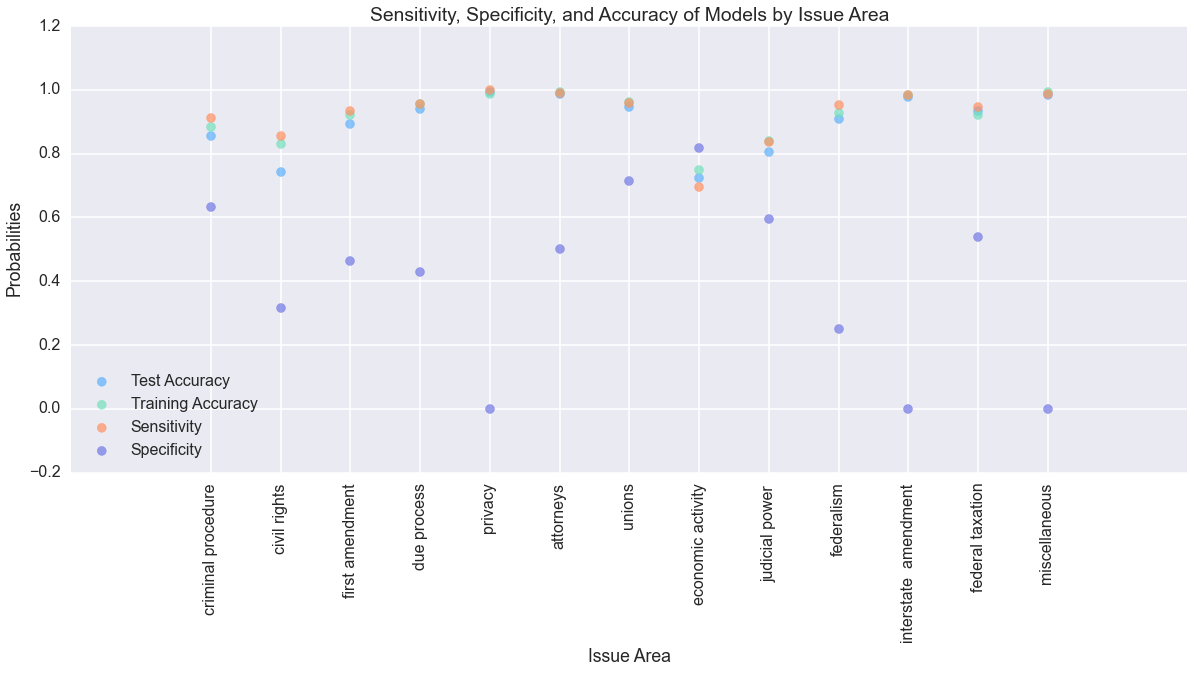

In [191]:
# plot training accuracy of each model
plt.figure(figsize=(20,8))
plt.scatter(range(len(model_df.test_accuracy)),model_df.test_accuracy, color="#5db0fd",label="Test Accuracy",s=80,alpha=0.7)
plt.scatter(range(len(model_df.training_accuracy)),model_df.training_accuracy, color="#73e1bd",label="Training Accuracy",s=80,alpha=0.7)
plt.scatter(range(len(model_df.sensitivity)),model_df.sensitivity, color="#ff9060",label="Sensitivity",s=80,alpha=0.7)
plt.scatter(range(len(model_df.specificity)),model_df.specificity, color="#7077e5",label="Specificity",s=80,alpha=0.7)
plt.xticks(np.arange(0,13,1),issue_areas[:-1], rotation=90)
plt.title("Sensitivity, Specificity, and Accuracy of Models by Issue Area")
plt.xlabel("Issue Area")
plt.ylabel("Probabilities")
plt.legend(loc="lower left")
plt.show()

In [281]:
predictions_df = pd.DataFrame(predict_dict)
predictions_df.head()

,attorneys,civil rights,conservative,criminal procedure,due process,economic activity,federal taxation,federalism,first amendment,interstate amendment,judicial power,liberal,miscellaneous,neutral,privacy,unions
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1


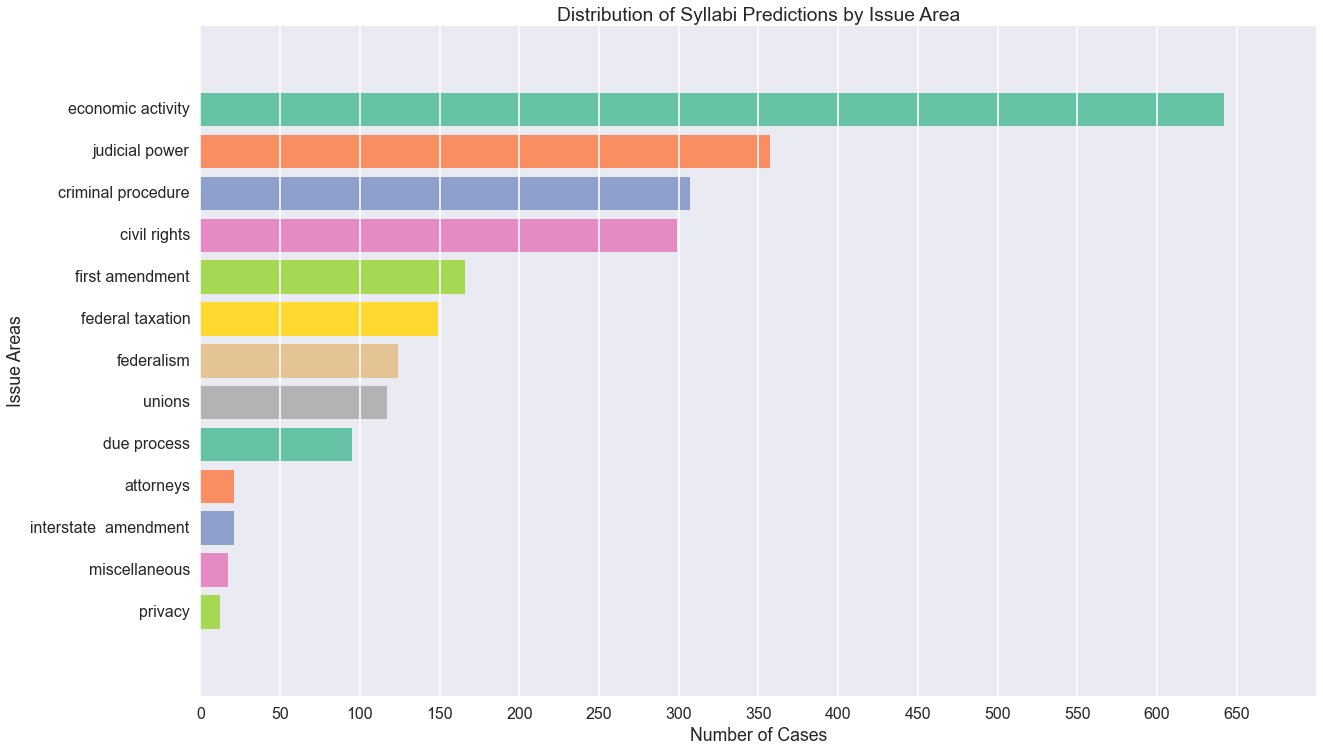

In [194]:
# plot distribution of all cases by issue type
import collections

issue_dict = {}
for issue in issue_areas[:-1]:
    issue_dict[issue] = sum(predictions_df[issue])

sorted_dict = collections.OrderedDict()
sorted_vals = sorted(issue_dict.values(),reverse=True)
sorted_keys = sorted(issue_dict, key=issue_dict.get,reverse=True)
for key, val in zip(sorted_keys,sorted_vals):
    sorted_dict[key] = val

plt.figure(figsize=(20,12))
plt.grid(zorder=3)
plt.barh(range(len(sorted_dict)),sorted_dict.values(),align='center',color=sns.color_palette("Set2", 14),linewidth=0,zorder=0)
plt.gca().yaxis.grid(False)
plt.gca().invert_yaxis()
plt.yticks(range(len(sorted_dict)),sorted_dict.keys())
plt.xticks(np.arange(0,700,50))
plt.title("Distribution of Syllabi Predictions by Issue Area")
plt.xlabel("Number of Cases")
plt.ylabel("Issue Areas")
plt.show()

Another way to explore our results is to determine how many topics were assigned to each case. We can do this by summing all of the binary columns by row and visualizing the distribution of cases.

In [376]:
predictions_df["num_categories"] = predictions_df.sum(axis=1)

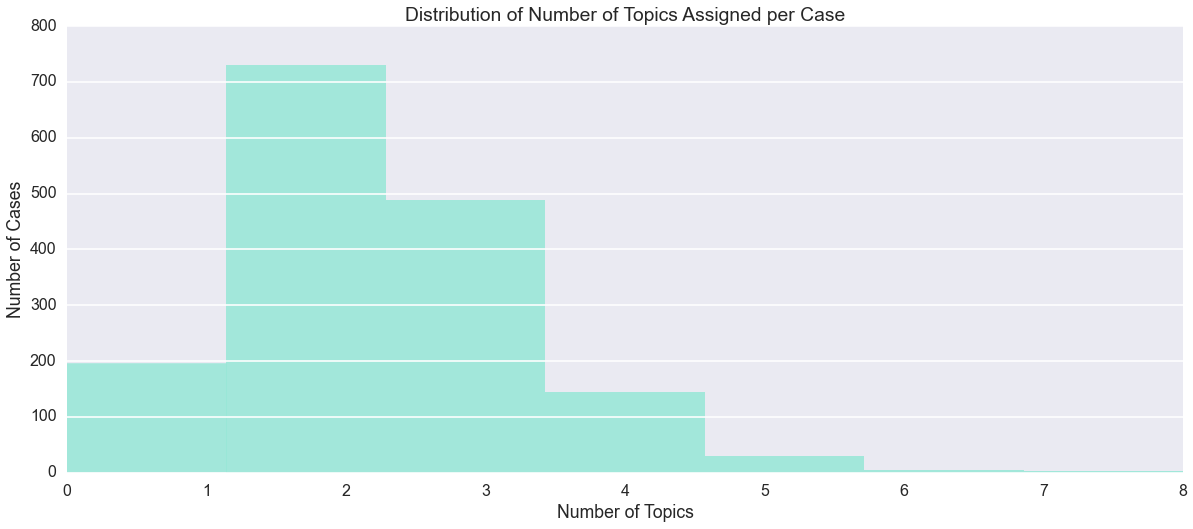

In [377]:
plt.figure(figsize=(20,8))
plt.hist(predictions_df.num_categories,bins=7,alpha=0.7,color="#84e7d1",linewidth=0,zorder=0)
plt.grid(zorder=3)
plt.gca().xaxis.grid(False)
plt.title("Distribution of Number of Topics Assigned per Case")
plt.xlabel("Number of Topics")
plt.ylabel("Number of Cases")
plt.show()

The histogram above is very right-skewed, and it seems that most cases were assigned to one or two topics (no more than six). In order to understand which cases were most difficult to classify, we can explore the "edge cases" in which 5 or more topics were assigned to a single case.

In [251]:
for index in list(predictions_df[predictions_df["num_categories"] >= 5].index):
    print sample_df.iloc[index].case
    print "-----------"
    print sample_df.iloc[index].year
    print issue_areas[sample_df.iloc[index].issueArea-1]
    print 

United States v. California
-----------
1947
federalism

BP America Production Co. v. Burton
-----------
2006
judicial power

Republic of Austria v. Altman
-----------
2004
criminal procedure

Richardson v. McKnight
-----------
1997
civil rights

United States v. Louisiana
-----------
1975
federalism



### Applying Naive Bayes to Partisanship 

In addition to topic areas, we can assign decision directions (partisan areas) to cases using the same method of Naive Bayes classification. This analysis might be interesting in yielding words that are indicative of liberal, conservative, and neutral legal positions.

CONSERVATIVE
---------------
Accuracy on training data: 0.65
Accuracy on test data:     0.59
------
True positives: 180
False positives: 123
False negatives: 73
True negatives: 103
------
Words yielding highest P(conservative | word)
             defense 0.59
              intent 0.58
      constitutional 0.58
           defendant 0.58
           amendment 0.57
          reasonable 0.56
           procedure 0.56
            standard 0.56
             hearing 0.56
             process 0.55
False positive cases:
---------------------------
Kimmelman v. Morrison
League of United Latin American Citizens v. Perry
Berkemer v. McCarty
City of Riverside v. Rivera
Banks v. Dretke

False negative cases:
--------------------------
Cope v. Anderson
Banco Nacional de Cuba v. Sabbatino
Levinson v. Spector Motor Service
United States v. Rock Island Motor Transit Co.
United States v. Louisiana


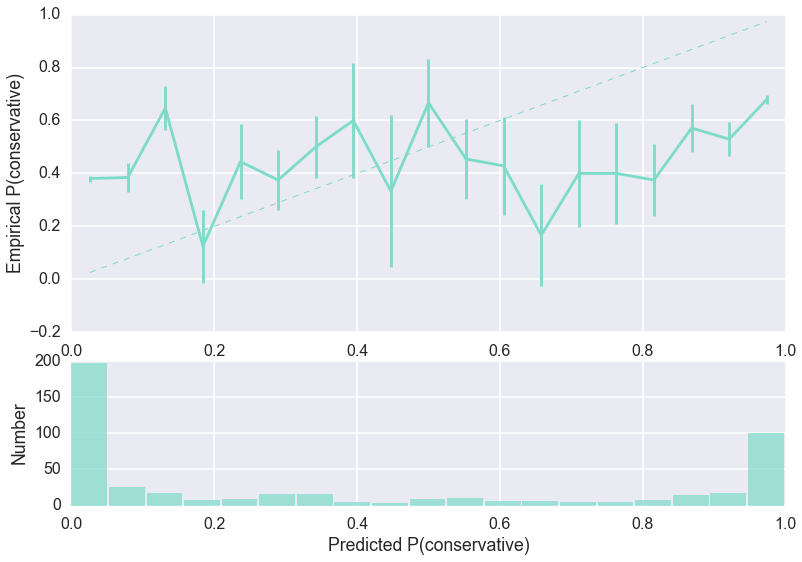

In [262]:
run_multinb(sample_df, decision_areas[0])

LIBERAL
---------------
Accuracy on training data: 0.64
Accuracy on test data:     0.56
------
True positives: 114
False positives: 94
False negatives: 119
True negatives: 152
------
Words yielding highest P(liberal | word)
            remanded 0.60
             purpose 0.59
              common 0.59
              claims 0.59
              action 0.59
        jurisdiction 0.59
                 act 0.58
            reversed 0.58
            february 0.58
                  16 0.58
False positive cases:
---------------------------
Universities Research Assn., Inc. v. Coutu
Vendo Co. v. Lektro-Vend Corp.
Pyramid Motor Freight Corp. v. Ispass
Cosmopolitan Shipping Co. v. McAllister
United States v. Rock Island Motor Transit Co.

False negative cases:
--------------------------
County of Allegheny v. ACLU
Berkemer v. McCarty
Kimmelman v. Morrison
League of United Latin American Citizens v. Perry
Banks v. Dretke


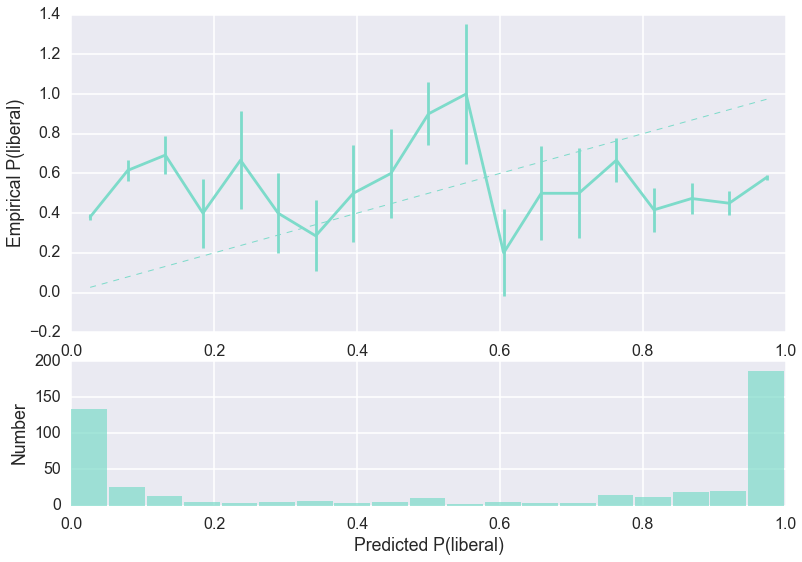

In [263]:
run_multinb(sample_df, decision_areas[1])

NEUTRAL
---------------
Accuracy on training data: 0.99
Accuracy on test data:     0.98
------
True positives: 468
False positives: 8
False negatives: 2
True negatives: 1
------
Words yielding highest P(neutral | word)
             entered 0.07
          department 0.06
             ordered 0.06
                  26 0.05
               among 0.05
            february 0.04
              having 0.04
         enforcement 0.04
          determined 0.04
           establish 0.04
False positive cases:
---------------------------
United States v. California
United States v. Louisiana
United States v. Louisiana
United States v. Maine
California State Lands Comm'n v. United States

False negative cases:
--------------------------
Colorado v. New Mexico
Nebraska v. Wyoming
Morrison v. Olson
Clinton v. City of New York
Mistretta v. United States


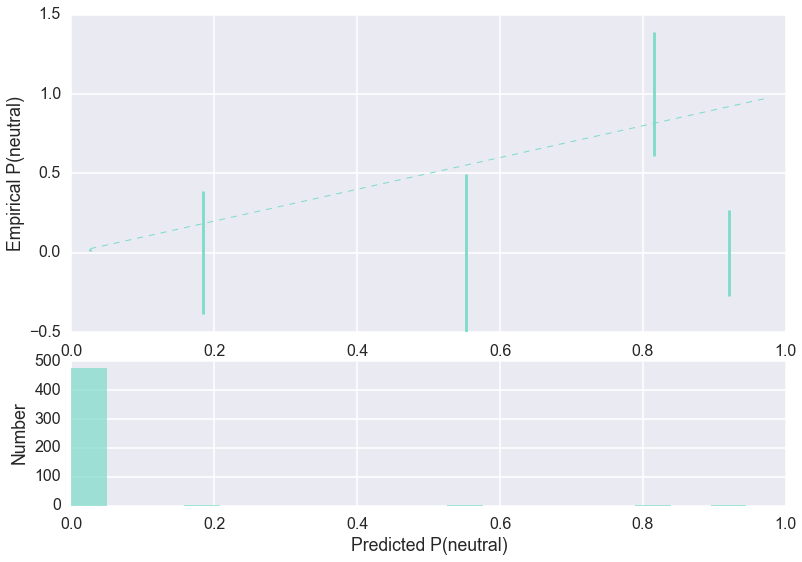

In [264]:
run_multinb(sample_df, decision_areas[2])

We can discern some interesting results from this analysis. First, we see that predictions overestimate conservative cases that have an empirical probability < 0.6 and underestimate conservative cases that have an empirical probability > 0.6. This pattern of performance also exists for liberal cases, in which the calibration plot intersects the y=x line around a predicted probability of 0.5. We can also glean some interesting keywords for conservative and liberal cases: <br><br>

**Conservative**: defense, intent, constitutional, amendment, reasonable <br>
**Liberal**: remanded, purpose, common, claims, reversed

<br> These words seem to be reasonable in the context of liberal legal positions (pro-union except in union antitrust, pro-government, anti-business, anti-employer, pro-competition, pro-person accused or convicted of crime, or denied a jury trial, pro-civil liberties or civil rights claimant, especially those exercising less protected civil rights, pro-neutrality in establishment clause cases, anti-government in the context of due process) and conservative legal positions (reverse of the aforementioned).